In [1]:
## 16. 강화학습 ##
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from functools import partial


## GPU 메모리 관리 ##
#1번 방법
config = tf.ConfigProto()
config.gpu_options.allow_growth = True #메모리 수요에 따라 할당

'''주의할 점은, 이 옵션은 메모리의 증식만 가능하다는 것. 연산이 끝나고 메모리가 필요없는 상황이라고 해서 할당된 메모리를 반납하지 않는다. 

Tensorflow 측에서는 그럴 경우 더 심한 메모리 파편화를 일으킬 수도 있다고 하니 판단은 독자의 몫.'''

'주의할 점은, 이 옵션은 메모리의 증식만 가능하다는 것. 연산이 끝나고 메모리가 필요없는 상황이라고 해서 할당된 메모리를 반납하지 않는다. \n\nTensorflow 측에서는 그럴 경우 더 심한 메모리 파편화를 일으킬 수도 있다고 하니 판단은 독자의 몫.'

In [3]:
import os, sys

# 맷플롯립 설정
from IPython.display import HTML
%matplotlib inline
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
plt.rc('font', family='Malgun Gothic')  # Windows
# matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

# 정책탐색

소프트웨어 에이전트가 행동을 결정하기 위해 사용하는 알고리즘을 <b style="font-size:1.4em;">정책</b>이라고 한다.

![policy](images/policy.png)

정책은 정해져 있는 알고리즘이 아니기 때문에, 어떠한 알고리즘도 될 수 있다. 예를들어 30분 동안 수집한 먼지의 양을 보상으로 받는 로봇 청소기가 있다고 하자. 이 청소기의 정책은 매 초마다 어떤 확률 $p$ 만큼 전진할 수도 있고, 또는 ($1-p$)의 확률로 랜덤하게 $-r$과 $+r$ 사이에서 회전하는 것일 수도 있다. 이 정책에는 무작위성이 포함되어 있으므로 <b style="font-size:1.1em;background-color:#AFA">확률적 정책(stochastic policy)</b>라고 한다.

이러한 정책을 가지고 '30분 동안 얼마나 많은 먼지를 수집할 것인가'에 대한 문제를 해결하기 위해 어떻게 로봇 청소기를 훈련(training) 시킬 수 있을까? 로봇 청소기 예제에는 변경이 가능한 두 개의 <b style="font-size:1.1em;background-color:#AFA">정책 파라미터(policy parameter)</b>가 있는데, 확률 $p$와 각도의 범위 $r$이다. $p$와 $r$은 다양한 조합이 될 수 있는데 이처럼 정책 파라미터의 범위를 <b style="font-size:1.1em;background-color:#AFA">정책 공간(policy space)</b>라고 하며, 정책 공간에서 가장 성능이 좋은 파라미터를 찾는 것을 <b style="font-size:1.1em;background-color:#AFA">정책 탐색(policy search)</b>라고 한다.

정책 탐색에는 다음과 같은 방법들이 있다.
<ul>
<li><b>단순한(naive) 방법</b> : 다양한 파라미터 값들로 실험한 뒤 가장 성능이 좋은 파라미터를 선택한다.</li>
<li><b>유전 알고리즘(genetic algorithm)</b> : 기존의 정책(부모)에서 더 좋은 정책(자식)을 만들어 내는 과정(진화)를 통해서 좋은 정책을 찾을 때까지 반복하는 방법이다.</li>
<li><b>정책 그래디언트(PG, policy gradient)</b> : 정책 파라미터에 대한 보상(reward)의 그래디언트(gradient)를 평가해서 높은 보상의 방향을 따르는 그래디언트로(즉, 경사상승법 gradient ascent) 파라미터를 업데이트하는 최적화 방법이다.</li>
</ul>

## ※렌더링 이슈 해결하기

일부 환경(Cart-Pole을 포함하여)은 rgb_array 모드를 설정하더라도 별도의 창을 띄우기 위해 디스플레이 접근이 필수적입니다. 일반적으로 이 창을 무시하면 됩니다. 주피터가 헤드리스(headless) 서버로 (즉 스크린이 없이) 실행중이면 예외가 발생합니다. 이를 피하는 한가지 방법은 Xvfb 같은 가짜 X 서버를 설치하는 것입니다. xvfb-run 명령을 사용해 주피터를 실행합니다:

$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

주피터가 헤드리스 서버로 실행 중이지만 Xvfb를 설치하기 번거롭다면 Cart-Pole에 대해서는 다음 렌더링 함수를 사용할 수 있습니다:

In [4]:
## 주피터노트북에서 OpenAt Gym 사용하기

from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # 문제없음, OpenAI 짐의 렌더링 함수를 사용합니다
except Exception:
    openai_cart_pole_rendering = False  # 가능한 X 서버가 없다면, 자체 렌더링 함수를 사용합니다

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # OpenAI 짐의 렌더링 함수를 사용합니다
        return env.render(mode="rgb_array")
    else:
        # Cart-Pole 환경을 위한 렌더링 (OpenAI 짐이 처리할 수 없는 경우)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # 파랑 초록 빨강
        pole_col = 0x669acc # 파랑 초록 빨강

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def update_scene(num, frames, patch):
    plt.close()  # 이전 그래프를 닫지 않으면 두 개의 그래프가 출력되는 matplotlib의 버그로 보입니다.
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

obs.shape : (4,)
obs : [ 0.03948192 -0.03092875 -0.02328401  0.01849316]
img.shape : (400, 600, 3)


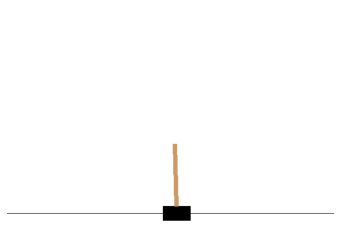

In [5]:
## OpenAt Gym
import gym

env = gym.make("CartPole-v0") #인공지능 모델이 동작할 환경을 만듬
obs = env.reset() #환경을 초기화
img = render_cart_pole(env, obs)

print('obs.shape :', obs.shape)
print('obs :', obs) #[ 카트위치, 속도, 막대기 각도, 각속도]
print('img.shape :', img.shape)
plot_cart_pole(env, obs) #화면에 환경 출력

In [7]:
env.action_space #Discrete(2), 가능한 행동 표시, 0(왼쪽)과 1(오른쪽)가능 

Discrete(2)

In [8]:
action = 1  # 오른쪽으로 가속
obs, reward, done, info = env.step(action)

print('obs :', obs) #새로운 관측값
print('reward :', reward) #보상
print('done :', done) #True이면 에피소드가 끝난 것(막대가 쓰러짐), 에피소드가 끝나면 화나경을 다시 사용하기 전 초기화 필요
print('info :', info) #다른 환경인 경우 추가적인 정보가 이 딕셔너리에 담김, 이 데이터는 훈련에 사용되면 안된다

obs : [ 0.03886334  0.16451925 -0.02291415 -0.28144425]
reward : 1.0
done : False
info : {}


In [10]:
def basic_policy(obs):
    angle = obs[2]
    #막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 가속, 오른쪽으로 기울어지면 카트를 오른쪽으로 가속
    return 0 if angle <0 else 1

frames, totals = [], []
for episode in range(20):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000):  # 영원히 실행되지 않게 최대 스텝을 1000번으로 설정
        img = render_cart_pole(env, obs)
        frames.append(img)
        
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)
    
print('totals mean :', np.mean(totals)) #게임 결과의 평균값
print('totals std :', np.std(totals)) #게임 결과의 표준편차
print('totals min :', np.min(totals)) #게임 결과의 최소값
print('totals max :', np.max(totals)) #게임 결과의 최대값

# ! apt-get update && apt-get install -y ffmpeg
# ! conda install -c conda-forge ffmpeg
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

totals mean : 46.0
totals std : 9.864076236526156
totals min : 25.0
totals max : 60.0
